#  Классификация изображений с помощью сверточных нейронных сетей

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/docs/stable/nn.html#convolution-layers
* https://pytorch.org/vision/0.16/transforms.html#v2-api-reference-recommended
* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
* https://kozodoi.me/blog/20210308/compute-image-stats
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.matshow.html

## Задачи для совместного разбора

1\. Рассмотрите основные возможности по созданию датасетов из `torchvision` и примеры работы основных слоев для создания сверточных нейронных сетей для анализа изображений.

In [ ]:
from torchvision import datasets, transforms

In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

cifar10_train = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)


100%|██████████| 9.91M/9.91M [00:00<00:00, 37.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.19MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.1MB/s]
100%|██████████| 170M/170M [00:02<00:00, 83.7MB/s]


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    self.fc1 = nn.Linear(32 * 8 * 8, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 32 * 8 * 8)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return x


In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

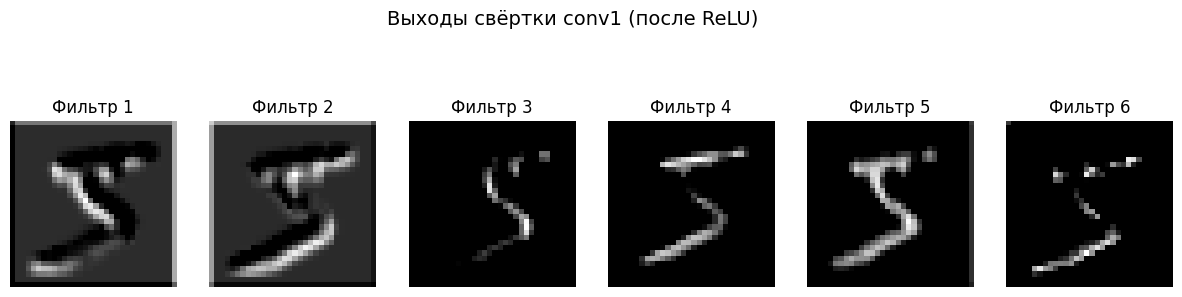

In [ ]:
image, label = mnist_train[0]
image = image.unsqueeze(0)


model = SimpleCNN()

with torch.no_grad():
  conv1_output = model.conv1(image)
  activated = F.relu(conv1_output)

fig, axes = plt.subplots(1, 6, figsize=(15, 4))
for i in range(6):
    axes[i].imshow(activated[0, i].numpy(), cmap='gray')
    axes[i].set_title(f'Фильтр {i+1}')
    axes[i].axis('off')
plt.suptitle('Выходы свёртки conv1 (после ReLU)', fontsize=14)
plt.show()

In [ ]:
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for images, labels in train_loader:
  optimizer.zero_grad()
  outputs = model(images)
  loss = criterion(outputs, labels)
  loss.backward()
  optimizer.step()
  print(f"Loss: {loss.item()}")
  break



Loss: 2.3086791038513184


2\. Реализуйте типовую архитектуру CNN для классификации изображений.

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes=10, input_channels=1):

        super(CNNClassifier, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Создайте датасет `CatBreeds` на основе данных из архива `cat_breeds_4.zip`. Используя преобразования `torchvision`, приведите картинки к размеру 300х300 и нормализуйте значения интенсивности пикселей (рассчитайте статистику для нормализации отдельно). Выведите на экран количество картинок в датасете,  размер одной картинки, количество уникальных классов. Разбейте датасет на обучающее и тестовое множество в соотношении 80 на 20%.

- [ ] Проверено на семинаре

In [2]:
import os
import zipfile
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split


archive_path = "cat_breeds_4.zip"
extract_dir = "cat_breeds_4"

if not os.path.exists(extract_dir):
    with zipfile.ZipFile(archive_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

dataset_path = extract_dir
initial_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root=dataset_path, transform=initial_transform)

def calculate_mean_std(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=64, num_workers=4)
    mean = 0.0
    std = 0.0
    total_images = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples

    mean /= total_images
    std /= total_images
    return mean, std

mean, std = calculate_mean_std(dataset)
print(f"Среднее: {mean}")
print(f"Стандартное отклонение: {std}")

transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

normalized_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

train_size = int(0.8 * len(normalized_dataset))
test_size = len(normalized_dataset) - train_size
train_dataset, test_dataset = random_split(normalized_dataset, [train_size, test_size])

print(f"Количество картинок в датасете: {len(normalized_dataset)}")
print(f"Размер одной картинки: {normalized_dataset[0][0].shape}")
print(f"Количество уникальных классов: {len(normalized_dataset.classes)}")
print(f"Размер обучающего датасета: {len(train_dataset)}")
print(f"Размер тестового датасета: {len(test_dataset)}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Среднее: tensor([0.5000, 0.4514, 0.4066])
Стандартное отклонение: tensor([0.2324, 0.2273, 0.2228])
Количество картинок в датасете: 4000
Размер одной картинки: torch.Size([3, 300, 300])
Количество уникальных классов: 1
Размер обучающего датасета: 3200
Размер тестового датасета: 800


<p class="task" id="2"></p>

2\. Решите задачу классификации на основе датасета из предыдущего задания, не используя сверточные слои. Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики accuracy на обучающем и тестовом множестве в зависимости от эпохи. Выведите на экран итоговое значение метрики accuracy на обучающем и тестовом множестве. Выведите на экран количество параметров модели.   

- [ ] Проверено на семинаре

Epoch [1/10], Loss: 73.9833, Train Accuracy: 0.3281, Test Accuracy: 0.3362
Epoch [2/10], Loss: 18.0662, Train Accuracy: 0.4462, Test Accuracy: 0.3713
Epoch [3/10], Loss: 7.6671, Train Accuracy: 0.5297, Test Accuracy: 0.3488
Epoch [4/10], Loss: 5.9018, Train Accuracy: 0.5831, Test Accuracy: 0.3787
Epoch [5/10], Loss: 3.1377, Train Accuracy: 0.6375, Test Accuracy: 0.3738
Epoch [6/10], Loss: 2.2590, Train Accuracy: 0.6922, Test Accuracy: 0.3862
Epoch [7/10], Loss: 2.2934, Train Accuracy: 0.7050, Test Accuracy: 0.3812
Epoch [8/10], Loss: 2.1013, Train Accuracy: 0.6850, Test Accuracy: 0.3850
Epoch [9/10], Loss: 1.5496, Train Accuracy: 0.7553, Test Accuracy: 0.3850
Epoch [10/10], Loss: 1.1860, Train Accuracy: 0.7828, Test Accuracy: 0.3925


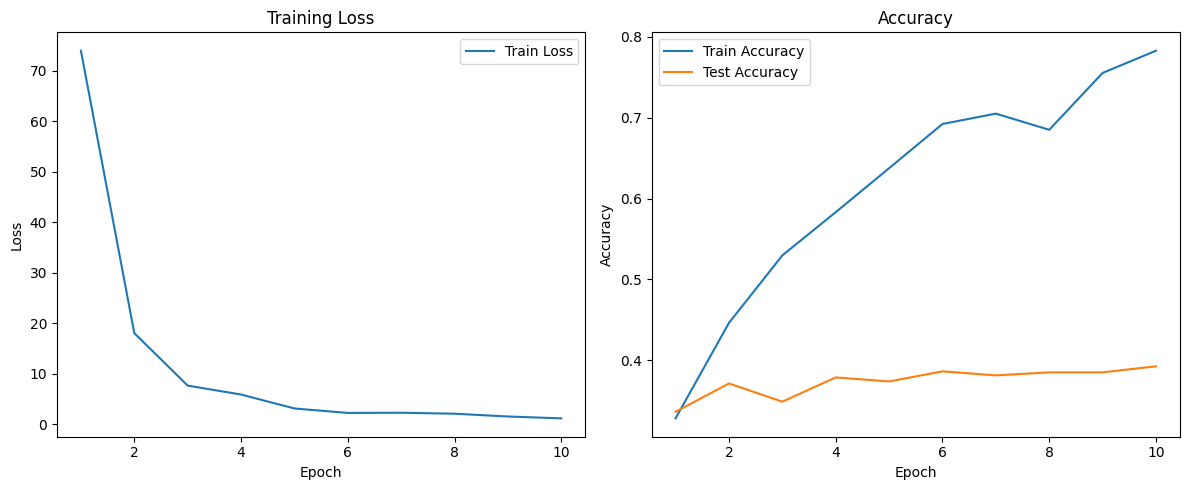

Итоговое значение метрики accuracy на обучающем множестве: 0.7828
Итоговое значение метрики accuracy на тестовом множестве: 0.3925
Количество параметров модели: 138242564


In [ ]:
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

normalized_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

train_size = int(0.8 * len(normalized_dataset))
test_size = len(normalized_dataset) - train_size
train_dataset, test_dataset = random_split(normalized_dataset, [train_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

input_size = 3 * 300 * 300
hidden_size = 512
output_size = len(normalized_dataset.classes)

class FullyConnectedNet(nn.Module):
    def __init__(self):
        super(FullyConnectedNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = FullyConnectedNet()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)


    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

final_train_accuracy = train_accuracies[-1]
final_test_accuracy = test_accuracies[-1]
print(f"Итоговое значение метрики accuracy на обучающем множестве: {final_train_accuracy:.4f}")
print(f"Итоговое значение метрики accuracy на тестовом множестве: {final_test_accuracy:.4f}")

total_params = sum(p.numel() for p in model.parameters())
print(f"Количество параметров модели: {total_params}")

<p class="task" id="3"></p>

3\. Напишите функцию, которая выбирает несколько изображений из переданного набора данных и выводит их на экран в виде сетки с указанием над ними названия правильного класса и класса, предсказанного моделью. Воспользовавшись данной функцией, выведите прогнозы итоговой модели из предыдущей задачи по 6 случайным картинкам.

```
def show_examples(model, dataset, k=6):
    pass
```

- [ ] Проверено на семинаре

In [3]:
import random

def show_examples(model, dataset, k=6):

    model.eval()

    indices = random.sample(range(len(dataset)), k)

    fig, axes = plt.subplots(1, k, figsize=(15, 3))
    for i, idx in enumerate(indices):

        image, true_label = dataset[idx]
        true_class = dataset.dataset.classes[true_label]
        image_unnormalized = image * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
        image_unnormalized = image_unnormalized.permute(1, 2, 0).numpy()

        with torch.no_grad():
            output = model(image.unsqueeze(0))
            predicted_label = torch.argmax(output, dim=1).item()
            predicted_class = dataset.dataset.classes[predicted_label]


        ax = axes[i]
        ax.imshow(image_unnormalized.clip(0, 1))
        ax.set_title(f"True: {true_class}\nPred: {predicted_class}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

<ipython-input-21-b8d46635deac>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_unnormalized = image * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)


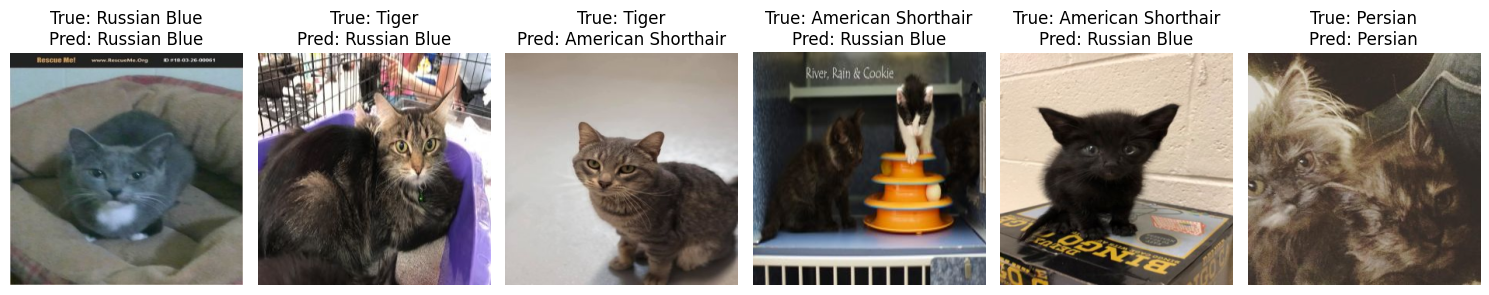

In [ ]:
show_examples(model, test_dataset, k=6)

<p class="task" id="4"></p>

4\. Решите задачу классификации на основе датасета из первого задания, используя сверточные слои. Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики accuracy на обучающем и тестовом множестве в зависимости от эпохи. Выведите на экран итоговое значение метрики accuracy на обучающем и тестовом множестве. Выведите на экран количество параметров модели. Воспользовавшись функцией из предыдущего задания, выведите прогнозы итоговой модели по 6 случайным картинкам.

- [ ] Проверено на семинаре

Epoch [1/5], Loss: 26.5515, Train Accuracy: 0.2750, Test Accuracy: 0.2000
Epoch [2/5], Loss: 13.4097, Train Accuracy: 0.3000, Test Accuracy: 0.2750
Epoch [3/5], Loss: 2.3189, Train Accuracy: 0.3563, Test Accuracy: 0.3750
Epoch [4/5], Loss: 1.3680, Train Accuracy: 0.4125, Test Accuracy: 0.2500
Epoch [5/5], Loss: 1.3368, Train Accuracy: 0.2625, Test Accuracy: 0.2500


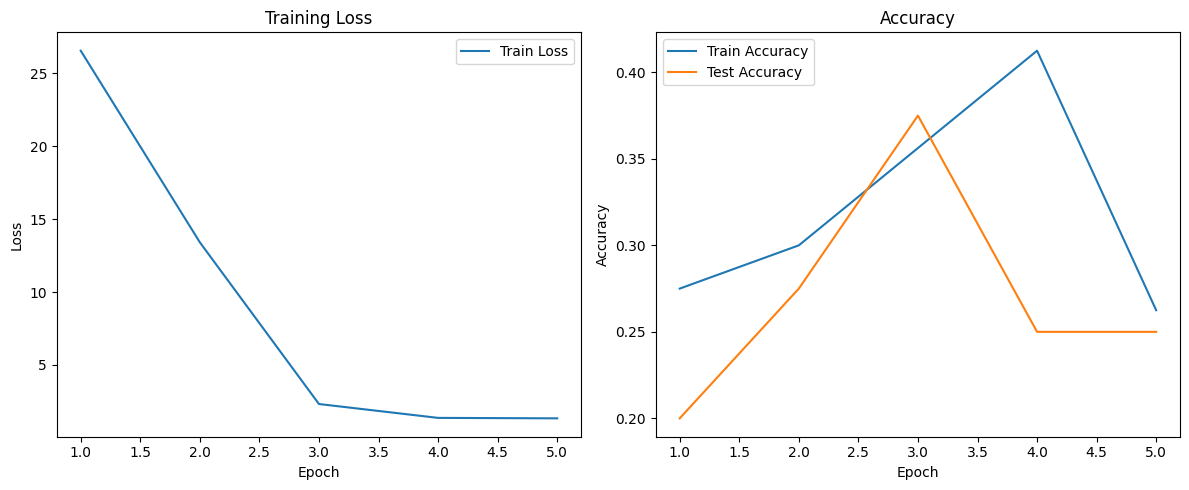

Итоговое значение метрики accuracy на обучающем множестве: 0.2625
Итоговое значение метрики accuracy на тестовом множестве: 0.2500
Количество параметров модели: 92167652


In [4]:
import os
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import defaultdict
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])


transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


dataset_path = "cat_breeds_4/cat_breeds_4"
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

def select_n_per_class(dataset, n):
    class_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    selected_indices = []
    for label, indices in class_indices.items():
        selected = random.sample(indices, min(n, len(indices)))
        selected_indices.extend(selected)

    return Subset(dataset, selected_indices)

filtered_dataset = select_n_per_class(full_dataset, n=50)


train_size = int(0.8 * len(filtered_dataset))
test_size = len(filtered_dataset) - train_size
train_dataset, test_dataset = random_split(filtered_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 75 * 75, 512),
            nn.ReLU(),
            nn.Linear(512, len(full_dataset.classes))
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

final_train_accuracy = train_accuracies[-1]
final_test_accuracy = test_accuracies[-1]
print(f"Итоговое значение метрики accuracy на обучающем множестве: {final_train_accuracy:.4f}")
print(f"Итоговое значение метрики accuracy на тестовом множестве: {final_test_accuracy:.4f}")

total_params = sum(p.numel() for p in model.parameters())
print(f"Количество параметров модели: {total_params}")


<p class="task" id="5"></p>

5\. Проанализируйте обученную в предыдущей задаче модель, исследовав обученные ядра сверточных слоев. Выберите одно изображение из тестового набора данных и пропустите через первый сверточный слой модели. Визуализируйте полученные карты признаков.

- [ ] Проверено на семинаре

<ipython-input-5-a98e075fa825>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_unnormalized = image * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)


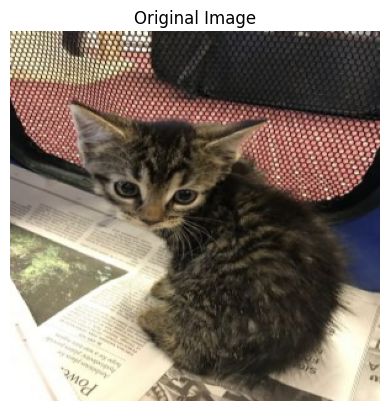

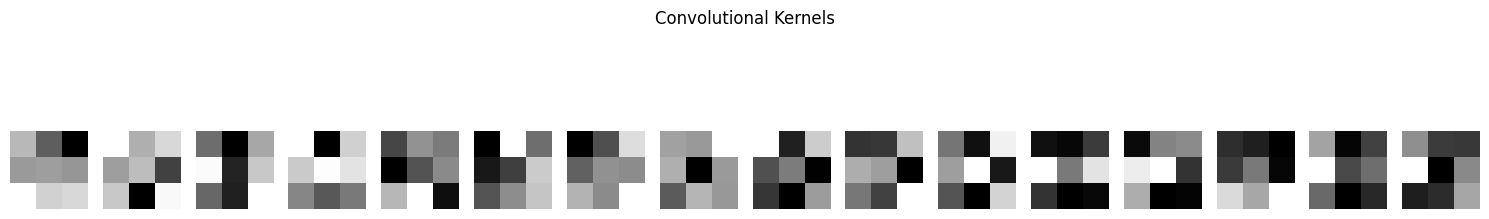

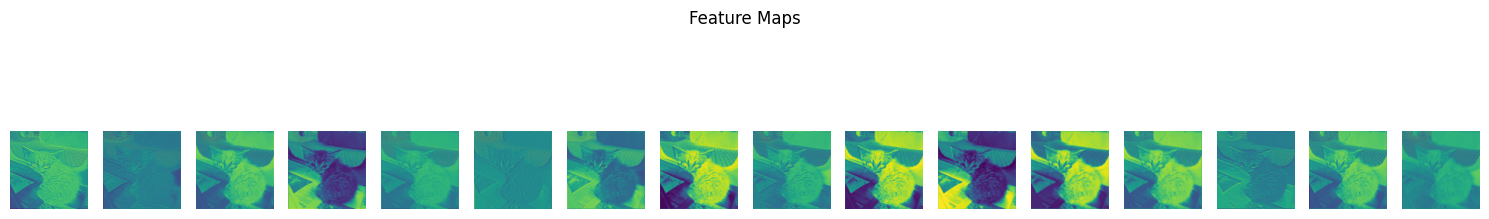

In [5]:
first_conv_layer = model.conv_layers[0]
kernels = first_conv_layer.weight.detach().cpu()

random_index = random.randint(0, len(test_dataset) - 1)
image, _ = test_dataset[random_index]
image_unnormalized = image * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)

model.eval()
with torch.no_grad():
    input_image = image.unsqueeze(0)
    feature_maps = first_conv_layer(input_image)

def visualize_kernels(kernels, title="Kernels"):
    num_kernels = kernels.shape[0]
    fig, axes = plt.subplots(1, num_kernels, figsize=(15, 3))
    for i in range(num_kernels):
        kernel = kernels[i].mean(dim=0).numpy()
        ax = axes[i]
        ax.imshow(kernel, cmap='gray')
        ax.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def visualize_feature_maps(feature_maps, title="Feature Maps"):
    num_maps = feature_maps.shape[1]
    fig, axes = plt.subplots(1, num_maps, figsize=(15, 3))
    for i in range(num_maps):
        feature_map = feature_maps[0, i].detach().cpu().numpy()
        ax = axes[i]
        ax.imshow(feature_map, cmap='viridis')
        ax.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plt.title("Original Image")
plt.imshow(image_unnormalized.permute(1, 2, 0).clip(0, 1))
plt.axis("off")
plt.show()

visualize_kernels(kernels, title="Convolutional Kernels")

visualize_feature_maps(feature_maps, title="Feature Maps")

## Обратная связь
- [ ] Хочу получить обратную связь по решению